In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 17 17:01:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import sklearn.metrics as sk

import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Mounted at /content/drive
Found device: Tesla T4, n_gpu: 1


In [11]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Project/data/model_predictions.csv')
df = df.reset_index()

bert_dict = {}
bert_text_dict = {}
bert_large_dict = {}
roberta_dict = {}
roberta_large_dict = {}
xlnet_dict = {}
xlnet_large_dict = {}
majority_voting_dict ={}
weighted_avg_dict = {}
weighted_avg_text_dict = {}
for index, row in df.iterrows():
  if row['bert_prediction'] != row['true_label']:
    if row['true_label'] not in bert_dict.keys():
      bert_dict[row['true_label']] = 1
      bert_text_dict[row['true_label']] = []
    else:
      bert_dict[row['true_label']] += 1
    bert_text_dict[row['true_label']].append([row['true_label'], row['bert_prediction'], row['text']])
  if row['bert_large_prediction'] != row['true_label']:
    if row['true_label'] not in bert_large_dict.keys():
      bert_large_dict[row['true_label']] = 1
    else:
      bert_large_dict[row['true_label']] += 1
  if row['roberta_prediction'] != row['true_label']:
    if row['true_label'] not in roberta_dict.keys():
      roberta_dict[row['true_label']] = 1
    else:
      roberta_dict[row['true_label']] += 1
  if row['roberta_large_prediction'] != row['true_label']:
    if row['true_label'] not in roberta_large_dict.keys():
      roberta_large_dict[row['true_label']] = 1
    else:
      roberta_large_dict[row['true_label']] += 1
  if row['xlnet_prediction'] != row['true_label']:
    if row['true_label'] not in xlnet_dict.keys():
      xlnet_dict[row['true_label']] = 1
    else:
      xlnet_dict[row['true_label']] += 1
  if row['xlnet_large_prediction'] != row['true_label']:
    if row['true_label'] not in xlnet_large_dict.keys():
      xlnet_large_dict[row['true_label']] = 1
    else:
      xlnet_large_dict[row['true_label']] += 1
  if row['majority_voting_prediction'] != row['true_label']:
    if row['true_label'] not in majority_voting_dict.keys():
      majority_voting_dict[row['true_label']] = 1
    else:
      majority_voting_dict[row['true_label']] += 1
  if row['weighted_avg_prediction'] != row['true_label']:
    if row['true_label'] not in weighted_avg_dict.keys():
      weighted_avg_dict[row['true_label']] = 1
      weighted_avg_text_dict[row['true_label']] = []
    else:
      weighted_avg_dict[row['true_label']] += 1  
    weighted_avg_text_dict[row['true_label']].append([row['true_label'], row['weighted_avg_prediction'], row['text']])
print(bert_dict)
print(bert_large_dict)
print(roberta_dict)
print(roberta_large_dict)
print(xlnet_dict)
print(xlnet_large_dict)
print(majority_voting_dict)
print(weighted_avg_dict)

{0: 45, 4: 41, 6: 19, 8: 13, 3: 20, 1: 27, 5: 25, 9: 16, 7: 39, 2: 19}
{0: 52, 4: 28, 6: 28, 8: 25, 3: 24, 5: 28, 7: 33, 9: 18, 1: 16, 2: 19}
{4: 27, 6: 18, 3: 25, 8: 17, 5: 23, 0: 53, 1: 23, 7: 36, 2: 22, 9: 19}
{4: 25, 6: 38, 3: 15, 1: 11, 8: 18, 5: 25, 0: 33, 7: 33, 9: 16, 2: 15}
{4: 26, 6: 30, 8: 23, 3: 28, 1: 29, 5: 28, 0: 41, 7: 35, 2: 12, 9: 17}
{4: 30, 6: 40, 3: 21, 8: 21, 5: 18, 0: 34, 7: 29, 1: 15, 2: 14, 9: 12}
{4: 27, 6: 24, 3: 17, 8: 16, 5: 24, 0: 36, 7: 33, 1: 17, 2: 16, 9: 11}
{4: 27, 6: 17, 3: 19, 8: 16, 5: 21, 0: 44, 7: 33, 1: 14, 2: 12, 9: 10}


In [6]:
def map_label_to_names(dict):
  dict['depression'] = dict.pop(0)
  dict['adhd'] = dict.pop(1)
  dict['anxiety'] = dict.pop(2)
  dict['autism'] = dict.pop(3)
  dict['bipolar'] = dict.pop(4)
  dict['bpd'] = dict.pop(5)
  dict['suicidal'] = dict.pop(6)
  dict['schizophrenia'] = dict.pop(7)
  dict['psychosis'] = dict.pop(8)
  dict['no mental illness'] = dict.pop(9)
  
  return dict

In [7]:
bert_dict = map_label_to_names(bert_dict)
bert_large_dict = map_label_to_names(bert_large_dict)
roberta_dict = map_label_to_names(roberta_dict)
roberta_large_dict = map_label_to_names(roberta_large_dict)
xlnet_dict = map_label_to_names(xlnet_dict)
xlnet_large_dict = map_label_to_names(xlnet_large_dict)
majority_voting_dict = map_label_to_names(majority_voting_dict)
weighted_avg_dict = map_label_to_names(weighted_avg_dict)
weighted_avg_text_dict = map_label_to_names(weighted_avg_text_dict)

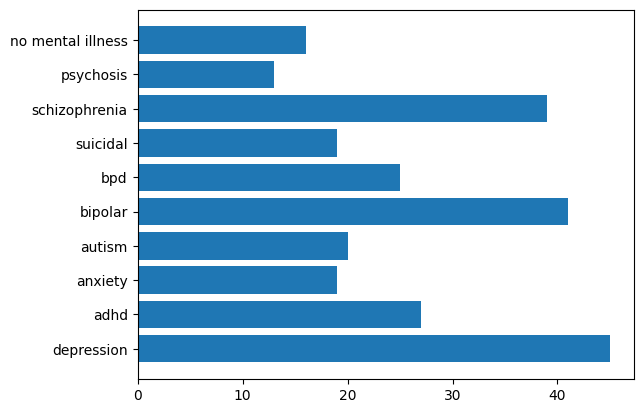

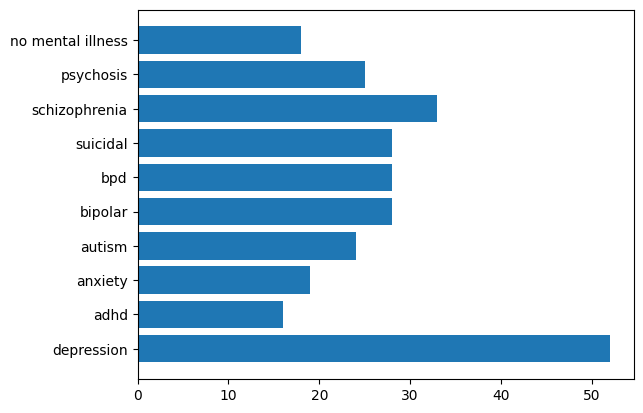

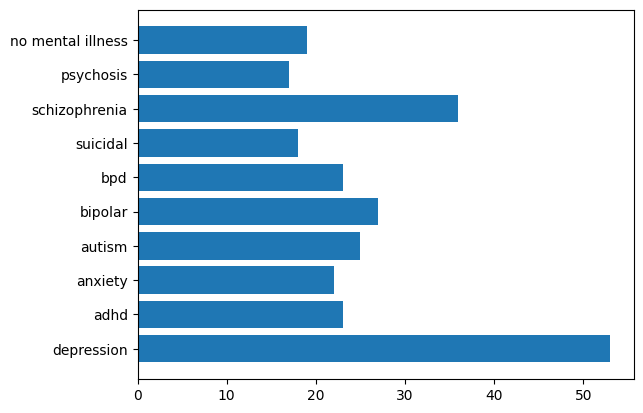

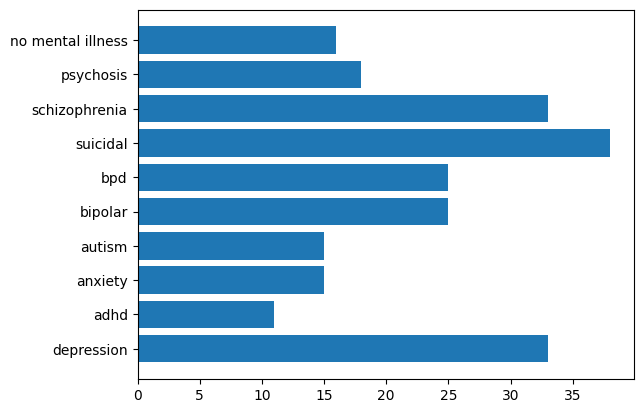

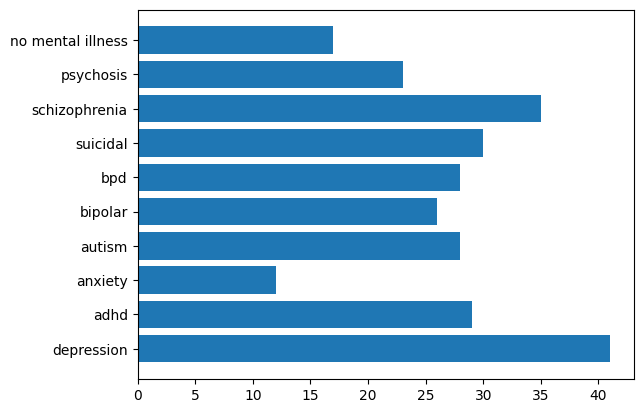

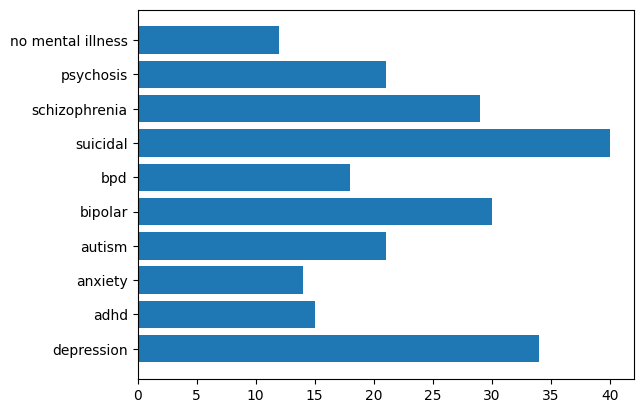

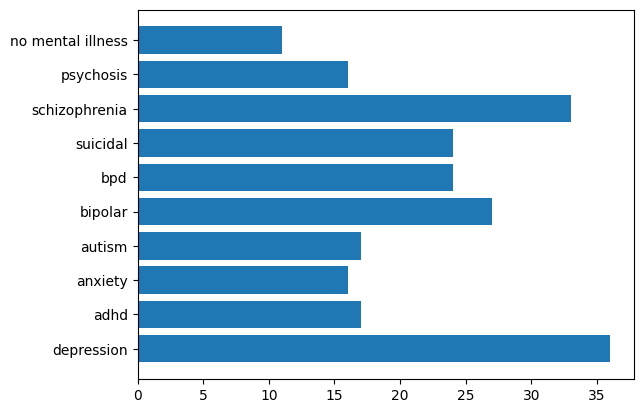

In [12]:
import matplotlib.pyplot as plt

plt.barh(*zip(*bert_dict.items()))
plt.show()

plt.barh(*zip(*bert_large_dict.items()))
plt.show()


plt.barh(*zip(*roberta_dict.items()))
plt.show()

plt.barh(*zip(*roberta_large_dict.items()))
plt.show()

plt.barh(*zip(*xlnet_dict.items()))
plt.show()

plt.barh(*zip(*xlnet_large_dict.items()))
plt.show()

plt.barh(*zip(*majority_voting_dict.items()))
plt.show()



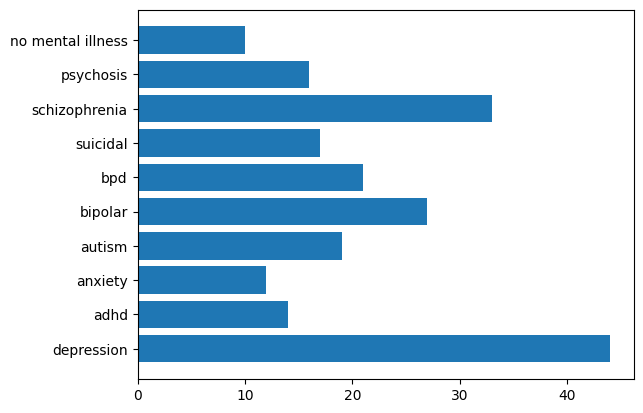

In [11]:
import matplotlib.pyplot as plt

plt.barh(*zip(*weighted_avg_dict.items()))
plt.show()

In [9]:
df = pd.read_csv('/content/drive/MyDrive/Project/data/model_predictions.csv')
true_labels = []
texts = []
predictions = []
for index, row in df.iterrows():
  if row['weighted_avg_prediction'] != row['true_label']:
    texts.append(row['text'])
    true_labels.append(row['true_label'])
    predictions.append(row['weighted_avg_prediction'])
df = pd.DataFrame(list(zip(texts, true_labels, predictions)), columns =['text', 'true_label', 'weighted_avg_prediction']) 
df.to_csv('/content/drive/MyDrive/Project/data/wegihted_avg_error_analysis.csv')


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Project/data/model_predictions.csv')
true_labels = []
texts = []
predictions = []
for index, row in df.iterrows():
  if row['bert_prediction'] != row['true_label']:
    texts.append(row['text'])
    true_labels.append(row['true_label'])
    predictions.append(row['bert_prediction'])
df = pd.DataFrame(list(zip(texts, true_labels, predictions)), columns =['text', 'true_label', 'bert_prediction']) 
df.to_csv('/content/drive/MyDrive/Project/data/bert_error_analysis.csv')


In [22]:
df = pd.read_csv('/content/drive/MyDrive/Project/data/model_predictions.csv')
true_labels = []
texts = []
predictions_bert = []
predictions_weighted = []
for index, row in df.iterrows():
  if row['bert_prediction'] != row['true_label'] and row['weighted_avg_prediction'] == row['true_label']:
    texts.append(row['text'])
    true_labels.append(row['true_label'])
    predictions_bert.append(row['bert_prediction'])
    predictions_weighted.append(row['weighted_avg_prediction'])
df = pd.DataFrame(list(zip(texts, true_labels, predictions_bert, predictions_weighted)), columns =['text', 'true_label', 'bert_prediction', 'weighted_avg_prediction']) 
df.to_csv('/content/drive/MyDrive/Project/data/wrong_bert_error_analysis.csv')


In [23]:
df = pd.read_csv('/content/drive/MyDrive/Project/data/model_predictions.csv')
true_labels = []
texts = []
predictions_bert = []
predictions_weighted = []
for index, row in df.iterrows():
  if row['bert_prediction'] == row['true_label'] and row['weighted_avg_prediction'] != row['true_label']:
    texts.append(row['text'])
    true_labels.append(row['true_label'])
    predictions_bert.append(row['bert_prediction'])
    predictions_weighted.append(row['weighted_avg_prediction'])
df = pd.DataFrame(list(zip(texts, true_labels, predictions_bert, predictions_weighted)), columns =['text', 'true_label', 'bert_prediction', 'weighted_avg_prediction']) 
df.to_csv('/content/drive/MyDrive/Project/data/wrong_weighted_avg_error_analysis.csv')


In [24]:
df = pd.read_csv('/content/drive/MyDrive/Project/data/model_predictions.csv')
true_labels = []
texts = []
predictions_bert = []
predictions_weighted = []
for index, row in df.iterrows():
  if row['bert_prediction'] != row['true_label'] and row['weighted_avg_prediction'] != row['true_label']:
    texts.append(row['text'])
    true_labels.append(row['true_label'])
    predictions_bert.append(row['bert_prediction'])
    predictions_weighted.append(row['weighted_avg_prediction'])
df = pd.DataFrame(list(zip(texts, true_labels, predictions_bert, predictions_weighted)), columns =['text', 'true_label', 'bert_prediction', 'weighted_avg_prediction']) 
df.to_csv('/content/drive/MyDrive/Project/data/wrong_both_error_analysis.csv')


array([[ 45,   1,   5,   0,   1,  10,  23,   1,   2,   1],
       [  1,  70,   5,   1,   1,   1,   0,   1,   0,   4],
       [  1,   3,  68,   1,   2,   0,   2,   0,   1,   2],
       [  1,   4,   5,  64,   1,   2,   1,   0,   2,   3],
       [  5,   2,   1,   0,  61,   8,   0,   2,   9,   0],
       [  4,   1,   2,   0,   4,  55,   7,   0,   3,   0],
       [  8,   0,   4,   1,   3,   0,  57,   0,   1,   0],
       [  2,   2,   0,   1,   2,   2,   2,  20,  22,   0],
       [  1,   0,   1,   0,   5,   2,   3,   4,  62,   0],
       [  1,   1,   6,   1,   0,   0,   1,   0,   0, 152]])

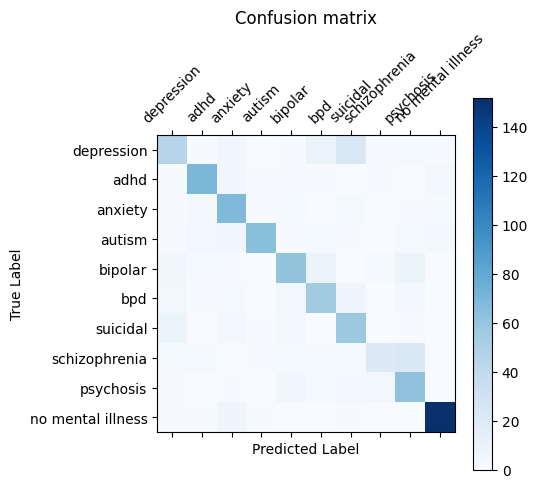

<Figure size 1500x800 with 0 Axes>

In [18]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap='Blues'):
    plt.matshow(df_confusion, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, ['depression', 'adhd', 'anxiety', 'autism', 'bipolar', 'bpd', 'suicidal', 'schizophrenia', 'psychosis', 'no mental illness'], rotation=90)
    plt.yticks(tick_marks, ['depression', 'adhd', 'anxiety', 'autism', 'bipolar', 'bpd', 'suicidal', 'schizophrenia', 'psychosis', 'no mental illness'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.figure(figsize=(15,8))


df_confusion = pd.crosstab(df['true_label'].to_numpy(), df['weighted_avg_prediction'].to_numpy())
plot_confusion_matrix(df_confusion)

confusion_matrix(df['true_label'].to_numpy(), df['weighted_avg_prediction'].to_numpy())

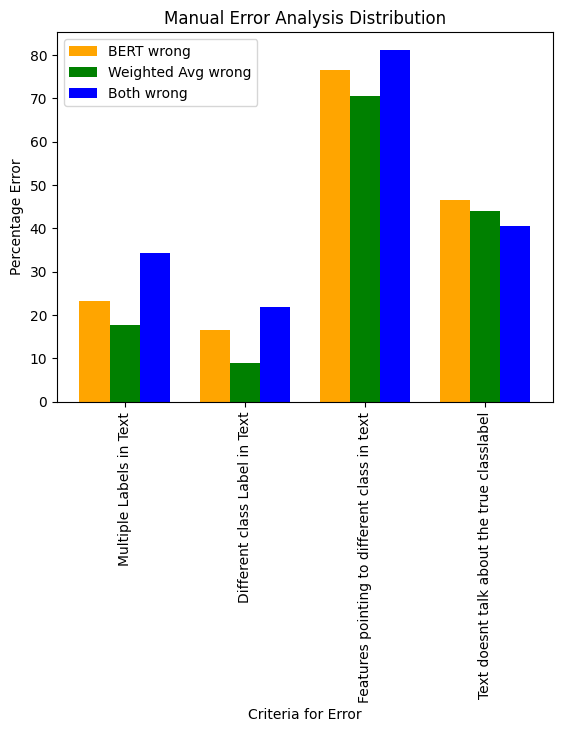

In [24]:
import numpy as np
import matplotlib.pyplot as plt
  
N = 4
ind = np.arange(N) 
width = 0.25
  
xvals = [7/30 * 100, 5/30 * 100, 23/30 * 100,14/30 * 100]
bar1 = plt.bar(ind, xvals, width, color = 'orange')
  
yvals = [6/34 * 100, 3/34 * 100, 24/34 * 100, 15/34 * 100]
bar2 = plt.bar(ind+width, yvals, width, color='g')
  
zvals = [11/32 * 100, 7/32 * 100, 26/32 * 100,13/32 * 100]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'blue')
  
plt.xlabel("Criteria for Error")
plt.ylabel('Percentage Error')
plt.title("Manual Error Analysis Distribution")
  
plt.xticks(ind+width,['Multiple Labels in Text','Different class Label in Text','Features pointing to different class in text','Text doesnt talk about the true classlabel'], rotation=90)
plt.legend( (bar1, bar2, bar3), ('BERT wrong', 'Weighted Avg wrong', 'Both wrong') )
plt.show()